In [ ]:
#import libraries
import dlib
import cv2
import numpy as np
from PIL import Image #work with images
import os
import zipfile
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn
from google.colab.patches import cv2_imshow

In [ ]:
#path of dataset
path="/content/drive/MyDrive/Computer Vision Masterclass/Datasets/yalefaces.zip"

#uncompress the file
zip_obj = zipfile.ZipFile(file=path, mode='r')  #read mode
zip_obj.extractall('./')  #extract in current folder
zip_obj.close() #release memory

In [ ]:
#detection of 68 facial points
face_detector = dlib.get_frontal_face_detector()
points_detector = dlib.shape_predictor('/content/drive/MyDrive/Computer Vision Masterclass/Weights/shape_predictor_68_face_landmarks.dat')
face_descriptor_extractor = dlib.face_recognition_model_v1('/content/drive/MyDrive/Computer Vision Masterclass/Weights/dlib_face_recognition_resnet_model_v1.dat')

In [ ]:
index = {}  #contains path of each train image
idx = 0 #counter
face_descriptors= None  #face descriptors of all images

#path of train data
paths = [os.path.join('/content/yalefaces/train', f) for f in os.listdir('/content/yalefaces/train')]

for path in paths:
  #print(path)
  image = Image.open(path).convert('RGB') #read image
  image_np = np.array(image, 'uint8') #numpy representation of image
  face_detection = face_detector(image_np, 1) #face detector

  for face in face_detection:
    l, t, r, b = face.left(), face.top(), face.right(), face.bottom()
    cv2.rectangle(image_np, (l,t), (r,b), (0,0,255), 2) #draw rectangle
    points = points_detector(image_np, face)  #points detector
    for point in points.parts():
      cv2.circle(image_np, (point.x, point.y), 2, (0,255,0), 1) #draw circle

    face_descriptor = face_descriptor_extractor.compute_face_descriptor(image_np, points) #face descriptor
    face_descriptor = np.array([f for f in face_descriptor], dtype=np.float64)
    face_descriptor = face_descriptor.reshape((1,-1)) #reshaping for compatibility

    if(face_descriptors is None):
      face_descriptors = face_descriptor
    else:
      face_descriptors = np.concatenate((face_descriptors, face_descriptor), axis = 0)
    index[idx] = path
    idx += 1

  cv2_imshow(image_np)

In [ ]:
#detecting faces
threshold = 0.5 #threshold for recognising classes
predictions = []
expected_outs = []

paths = [os.path.join('/content/yalefaces/test', f) for f in os.listdir('/content/yalefaces/test')] #path of test data

for path in paths:
  image = Image.open(path).convert('RGB') #read image
  image_np = np.array(image, 'uint8')   #numpy representation of image
  face_detection = face_detector(image_np, 1) #face detector

  for face in face_detection:
    l, t, r, b = face.left(), face.top(), face.right(), face.bottom()
    cv2.rectangle(image_np, (l,t), (r,b), (0,0,255), 2) #draw rectangle

    points = points_detector(image_np, face)  #points detector

    for point in points.parts():
      cv2.circle(image_np, (point.x, point.y), 2, (0,255,0), 1) #draw circle

    face_descriptor = face_descriptor_extractor.compute_face_descriptor(image_np, points) #face descriptor
    face_descriptor = np.array([f for f in face_descriptor], dtype=np.float64)
    face_descriptor = face_descriptor.reshape((1,-1))     #reshaping for compatibility

    #calculating distance between faces
    #distance here means how different an image is different/similar to another image
    distances = np.linalg.norm(face_descriptor - face_descriptors, axis=1)  #distance between this test image with all train images (face_descriptors)
    min_index = np.argmin(distances)  #find index of minimum distant train image
    min_distance = distances[min_index] #min distance value

    if(min_distance <=threshold): #if calculated distance is lessthan or equal to threshold it is considered as the clas
      name_pred = int(os.path.split(index[min_index])[1].split('.')[0].replace('subject','')) #extracting class name from image name
    else:
      name_pred = 'Not Identified'  #for images which can't be identified

    name_real = int(os.path.split(path)[1].split('.')[0].replace('subject','')) #extract real name from file name

    predictions.append(name_pred)
    expected_outs.append(name_real)

    cv2.putText(image_np, 'Pred: '+str(name_pred), (10,30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,255))
    cv2.putText(image_np, 'Exp: ' +str(name_real),  (10,50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,255))

  cv2_imshow(image_np)

predictions = np.array(predictions)
expected_outs = np.array(expected_outs)

Accuracy : 100.0 %



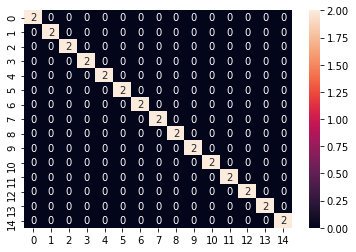

In [10]:
print("Accuracy :",accuracy_score(predictions, expected_outs)*100,"%",end='\n\n')

#confusion matrix
cm = confusion_matrix(predictions, expected_outs)

#heatmap visualisation
seaborn.heatmap(cm, annot=True);  #semicolon to hide message from matplotlib; annot - to see values